# UNETR-2D for mitochondria segmentation in 2D - 2. exeperiment
    
     Original Author: Aitor González


This time the model will be trained with the positive tiles only, exluding tiles with completly empty masks.

## Getting started

In [1]:
import os
from utils import *
from models import *

import numpy as np
import cv2
import gc
from matplotlib import pyplot as plt
from skimage import metrics

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras.backend import clear_session

set_gpu(gpu_id=0)
set_seed()

import tensorflow as tf
tf.config.list_physical_devices('GPU')

2025-02-07 15:29:40.163853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-07 15:29:40.194867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-07 15:29:40.204279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 15:29:40.228023: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-07 15:29:41.325707: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Data needs to be organized in the following way:

```
data/
    |-- train/
    |    |-- x/
    |    |      training-0001.tif
    |    |      ...
    |    |-- y/
    |    |      training_groundtruth-0001.tif
    |    |        ...
    |-- test/
    |    |-- x/
    |    |      testing-0001.tif
    |    |      ...
    |    |-- y/
    |    |      testing_groundtruth-0001.tif
    |    |      ...

```

## Parameters

In [2]:
data_path = '/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images'
# Training dataset
train_datasets = 'train'
# Test dataset
test_datasets = 'test'

In [3]:
## === Training parameters ===
# number of epochs
numEpochs = 100
# patience (if (patience <= 0): patience will not be used)
patience = 30
# learning rate
lr = 1e-4
# weight_decay  (for AdamW)
wd = 1e-5
# Scheduler: 'oneCycle', 'reduce', 'cosine',  None
schedule = 'oneCycle'
# Optimizer name: 'Adam', 'SGD', 'rmsprop', 'AdamW'
optimizer_name = 'AdamW'
# Loss function name: 'bce', 'bce_dice', 'mse'
loss_acronym = 'bce'
# batch size
batch_size_value = 6

In [4]:
## === Network parameters ===
# Network architecture: UNETR_2D, YNETR_2D,
model_name = 'UNETR_2D'
# initial filters (16 x num_channels)
num_filters = 32
# conv kernel initializer: 'glorot_uniform', 'he_normal'
kernel_init = 'he_normal'
# conv part activation function
activation = 'relu'
# patch size
patch_size = 16
# hidden dimension
hidden_dim = 64
# number of transformer encoders
transformer_layers = 4
# number of heads per MHA module
num_heads = 4
# transformer mlp dimentions
mlp_dim = [256, 64]
# number of output channels (number of classes)
out_channels = 1
# denoise type: cutout, gaussNoise, coarseSaltP, emulate_LR, gaussian_filter, defocusBlur, motionBlur, pixeldropout
posible_dataAug = []
# dropout value # [0.1, 0.1, 0.2, 0.2, 0.3] (list is also allowed)
dropout = 0.0
# multiple of ViT layers that will be used for each skip connection (Sm)
ViT_hidd_mult_skipC = 1
# Use Batch Normalization layers
batch_norm = True
# Use Data Augmentation
da = True
# tensorflow additional data augmentation layers (use tf layer, if multiple layers, then use sequential() and add them)
extra_tf_data_augmentation = None

In [5]:
# === Extra parameters ===
# Load weights for FineTunning
use_saved_model = False
# Path to save weights (After training)
out_dir = './model_weights'
# Path to save plots
img_out_dir = './plots'
# filenames for trained model weights (h5)
weights_filename = out_dir + '/weights-{}-src-{}-bce-nf-{}-bs-{}-{}-{}.weights.h5'.format(
                                                    model_name, train_datasets, num_filters, batch_size_value,
                                                    optimizer_name, 'None' if schedule is None else schedule )
# Weights file path (weights that will be loaded if use_saved_model is TRUE)
model_path = ''

# image input size (this does not change the data size!)
input_shape = (256,256,1)
# number of random patches (with number lower than 0, sequential patches will be used)
n_patches = -1

# evaluation parameters
# patch size
patch_h, patch_w = (256,256)
# relevant patch size
relevant_h, relevant_w = (128,128)

## Prepare the data

In [6]:
h_cuts = 0
v_cuts = 0

source_path = os.path.join(data_path, train_datasets)
print(source_path)
ds_imgs, ds_lbls = get_xy_image_list(source_path)


/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/train
Input images loaded: 10358 -- Label images loaded: 10358
	path: /media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/train


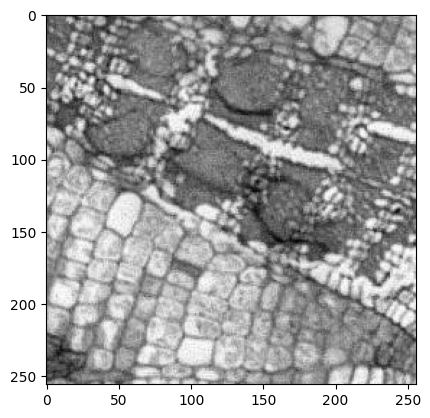

In [8]:
img = ds_imgs[0]
plt.imshow(img, cmap='gray')

In [11]:

h_cuts = 0
v_cuts = 0

source_path = os.path.join(data_path, train_datasets)
ds_imgs, ds_lbls = get_xy_image_list(source_path)

assert len(ds_imgs) > 0, 'There in NO data, check path: {}.'.format(source_path)
assert len(ds_imgs) == len(ds_lbls), 'There is different ammount of images and labels. Images: {}  Labels: {}'.format(len(ds_imgs), len(ds_lbls))

'''
print(len(ds_imgs))
print(len(ds_lbls))
print(type(ds_imgs[0]))
print(type(ds_lbls[0]))
print(ds_imgs[0].shape)
print(ds_lbls[0].shape)
'''

exp_h, exp_w, _ = input_shape

#print("h_cuts: {} \t v_cuts: {}".format(h_cuts, v_cuts))


# Y_test = np.expand_dims( np.asarray(Y_test, dtype=np.float32), axis=-1 ) 
ds_lbls = [mirror_border(x, exp_h, exp_w) for x in ds_lbls]
# ZERO PADDING (for 256x256 patches by default)
#ds_imgs = [add_padding(x) for x in ds_imgs]
#ds_lbls = [add_padding(x) for x in ds_lbls]

if n_patches < 0:
    # sequential patches
    ds_imgs = create_patches( ds_imgs, exp_h, exp_w )
    ds_lbls = create_patches( ds_lbls, exp_h, exp_w )

    #ds_imgs, ds_lbls = filter_patches(ds_imgs, ds_lbls)
else:
    # random patches
    p_ds_imgs = []
    p_ds_lbls = []
    while len(p_ds_imgs)<n_patches:
        a,b = create_random_patches( ds_imgs, ds_lbls, 1, [256, 256] )
        #a, b = filter_patches(a, b)
        p_ds_imgs = p_ds_imgs + a
        p_ds_lbls = p_ds_lbls + b
    ds_imgs = p_ds_imgs[:n_patches]
    ds_lbls = p_ds_lbls[:n_patches]

'''
print(type(ds_imgs))
print(type(ds_lbls))
print(len(ds_imgs))
print(len(ds_lbls))
print(ds_imgs[0])
print(ds_lbls[0])
print(ds_imgs[0].shape)
print(ds_lbls[0].shape)
print(ds_imgs[1].shape)
print(ds_lbls[1].shape)
'''

# ds_imgs = np.expand_dims(ds_imgs, axis=-1)
# ds_lbls = np.expand_dims(ds_lbls, axis=-1)

input_images = np.array(ds_imgs, dtype=np.ndarray)
gt_labels = np.array(ds_lbls, dtype=np.ndarray)

print("DEBUG")

print(type(input_images))imagecodecs
print(type(gt_labels))
print(input_images.shape)
print(gt_labels.shape)

input_images = np.expand_dims(input_images, axis=-1)
gt_labels = np.expand_dims(gt_labels, axis=-1)
train_data_size = input_images.shape[0] * 0.9
val_data_size = input_images.shape[0] * 0.1

print('\n Data shape:',input_images.shape)
print('\n labels shape:',gt_labels.shape)

print(train_data_size)
print(val_data_size)

Input images loaded: 10358 -- Label images loaded: 10358
	path: /media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/train
DEBUG
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(10358, 256, 256)
(10358, 256, 256)

 Data shape: (10358, 256, 256, 1)

 labels shape: (10358, 256, 256, 1)
9322.2
1035.8


In [12]:
input_images[10000].shape



(256, 256, 1)

In [13]:
# get crappify function
crappify = get_crappify(posible_dataAug) 
# Get generator
train_generator, val_generator = get_train_val_generators(  X_data = input_images,
                                                            Y_data = input_images if loss_acronym == 'mse' else gt_labels,
                                                            validation_split = 0.1,
                                                            rescale = 1./255,
                                                            # horizontal_flip=True if da else False,
                                                            # vertical_flip=True if da else False,
                                                            # rotation_range = 180 if da else 0,
                                                            #width_shift_range=0.2,
                                                            #height_shift_range=0.2,
                                                            #shear_range=0.2,
                                                            batch_size=batch_size_value,
                                                            show_examples=False,
                                                            preprocessing_function = crappify if loss_acronym == 'mse' else None,
                                                            val_preprocessing_function = crappify if loss_acronym == 'mse' else None, )
train_generator = (pair for pair in train_generator)
val_generator = (pair for pair in val_generator)

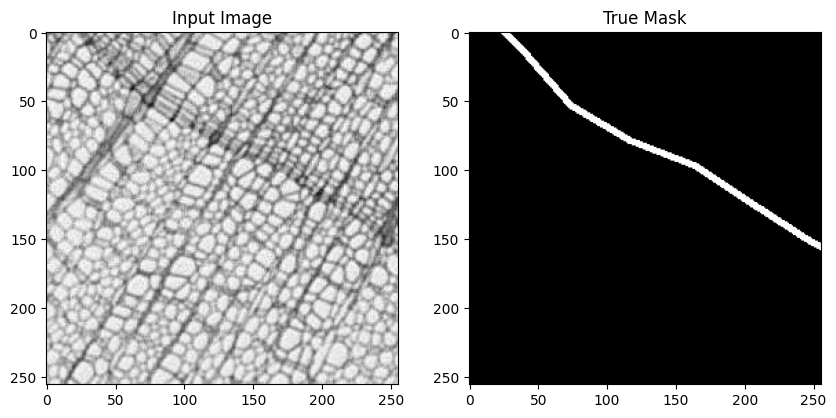

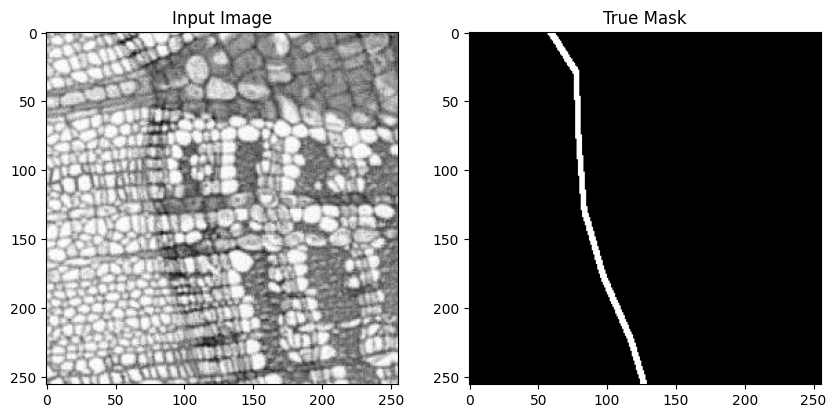

In [14]:
for x, y in train_generator:
    display([x[0,:,:,0],y[0,:,:,0]])
    break
for x, y in val_generator:
    display([x[0,:,:,0],y[0,:,:,0]])
    break

## Compile


In [15]:
# Free up RAM in case the model definition cells were run multiple times
clear_session()
gc.collect()

### CALLBACKS ###
callbacks = []

if patience > 0:
    # callback for early stop
    earlystopper = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)
    callbacks.append(earlystopper)

if schedule == 'oneCycle':
    # callback for one-cycle schedule
    steps = np.ceil(train_data_size / batch_size_value) * numEpochs
    #steps = np.ceil(len(X_train) / batch_size_value) * numEpochs
    lr_schedule = OneCycleScheduler(lr, steps)
    callbacks.append(lr_schedule)
elif schedule == 'reduce':
    # callback to reduce the learning rate in the plateau
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                            patience=patience, min_lr=(lr/10))
    callbacks.append(lr_schedule)
elif schedule == 'cosine':
    # this scheduler is not a callback
    steps = np.ceil(train_data_size / batch_size_value) * numEpochs
    lr = tf.keras.optimizers.schedules.CosineDecay(lr, steps)  


# create the network and compile it with its optimizer
if model_name == 'UNETR_2D':
    model = UNETR_2D(
            input_shape = input_shape,
            patch_size = patch_size,
            num_patches = (input_shape[0]**2)//(patch_size**2),
            projection_dim = hidden_dim,
            transformer_layers = transformer_layers,
            num_heads = num_heads,
            transformer_units = mlp_dim, 
            data_augmentation = extra_tf_data_augmentation,
            num_filters = num_filters,
            num_classes = out_channels,
            decoder_activation = activation,
            decoder_kernel_init = kernel_init,
            ViT_hidd_mult=ViT_hidd_mult_skipC,
            batch_norm = batch_norm,
            dropout = dropout,
        )
elif model_name == 'YNETR_2D':   
    model = YNETR_2D(
                input_shape = input_shape,
                patch_size = patch_size,
                num_patches = (input_shape[0]**2)//(patch_size**2),
                projection_dim = hidden_dim,
                transformer_layers = transformer_layers,
                num_heads = num_heads,
                transformer_units = mlp_dim, 
                data_augmentation = extra_tf_data_augmentation,
                num_filters = num_filters, 
                num_classes = out_channels,
                activation = activation,
                kernel_init = kernel_init,
                ViT_hidd_mult=ViT_hidd_mult_skipC,
                batch_norm = batch_norm,
                dropout = dropout,
            )
        

if optimizer_name == 'SGD':
    optim =  tf.keras.optimizers.SGD(
            lr=lr, momentum=0.99, decay=0.0, nesterov=False)
elif optimizer_name == 'Adam':
    optim = tf.keras.optimizers.Adam( learning_rate=lr )
elif optimizer_name == 'rmsprop':
    optim = tf.keras.optimizers.RMSprop( learning_rate=lr )
elif optimizer_name == 'AdamW':
    optim = tf.keras.optimizers.AdamW( weight_decay = wd, learning_rate=lr )

model.summary()

if loss_acronym == 'bce':
    loss_funct = 'binary_crossentropy'
elif loss_acronym == 'bce_dice':
    loss_funct = bce_dice_loss
elif loss_acronym == 'mse': # dont change this acronym (is used to know when is training for denoising)
    loss_funct = 'mean_squared_error'

if loss_acronym == 'mse':
    eval_metric = [psnr, ssim]
else:
    eval_metric = [jaccard_index]
                
# compile the model with the specific optimizer, loss function and metric
model.compile(optimizer=optim, loss=loss_funct, metrics=eval_metric)

2025-02-07 15:45:14.317232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13699 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:03:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 256) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 256, 64)   │     32,832 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256, 256)  │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256, 64)   │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256, 256)  │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256, 256)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256, 64)   │     16,448 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,247,009 (16.20 MB)

 Trainable params: 4,243,553 (16.19 MB)

 Non-trainable params: 3,456 (13.50 KB)

### show model architecture
Have a quick look at the resulting model architecture:

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Load saved model

In [ ]:
if use_saved_model:
    # Restore the weights
    model.load_weights(model_path) # change this

    # compile the model with the specific optimizer, loss function and metric
    model.compile(optimizer=optim, loss=loss_funct, metrics=eval_metric)
    print("Weights loaded, and compiled")


## Train model

In [17]:
history = model.fit(train_generator, validation_data=val_generator,
                    validation_steps=int(np.ceil(val_data_size/batch_size_value)),
                    steps_per_epoch=int(np.ceil(train_data_size/batch_size_value)),
                    epochs=numEpochs, callbacks=callbacks)

Epoch 1/100


I0000 00:00:1738939584.595608 3765675 service.cc:146] XLA service 0x7eaf040033b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738939584.595674 3765675 service.cc:154]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2025-02-07 15:46:25.453153: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-07 15:46:28.442217: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1738939593.135029 3765675 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738939593.270033 3765675 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00

   1/1554 ━━━━━━━━━━━━━━━━━━━━ 27:07:30 63s/step - jaccard_index: 0.0000e+00 - loss: 0.8109

I0000 00:00:1738939627.075189 3765675 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1552/1554 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - jaccard_index: 0.0000e+00 - loss: 0.2599

E0000 00:00:1738939741.548897 3765676 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738939741.686558 3765676 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738939742.891918 3765676 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738939743.166414 3765676 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738939743.940737 3765676 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

1554/1554 ━━━━━━━━━━━━━━━━━━━━ 219s 100ms/step - jaccard_index: 0.0000e+00 - loss: 0.2597 - val_jaccard_index: 0.0000e+00 - val_loss: 0.0453
Epoch 2/100
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 112s 72ms/step - jaccard_index: 0.0000e+00 - loss: 0.0361 - val_jaccard_index: 0.0000e+00 - val_loss: 0.0139
Epoch 3/100
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 113s 73ms/step - jaccard_index: 0.0000e+00 - loss: 0.0113 - val_jaccard_index: 0.0000e+00 - val_loss: 0.0052
Epoch 4/100
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 113s 73ms/step - jaccard_index: 0.0000e+00 - loss: 0.0043 - val_jaccard_index: 0.0000e+00 - val_loss: 0.0023
Epoch 5/100
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 112s 72ms/step - jaccard_index: 0.0000e+00 - loss: 0.0020 - val_jaccard_index: 0.0000e+00 - val_loss: 0.0012
Epoch 6/100
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 112s 72ms/step - jaccard_index: 0.0000e+00 - loss: 0.0011 - val_jaccard_index: 0.0000e+00 - val_loss: 7.7906e-04
Epoch 7/100
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 114s 73ms/step - jaccard_index: 0.0000e+00 - loss: 7

Plot loss - IoU

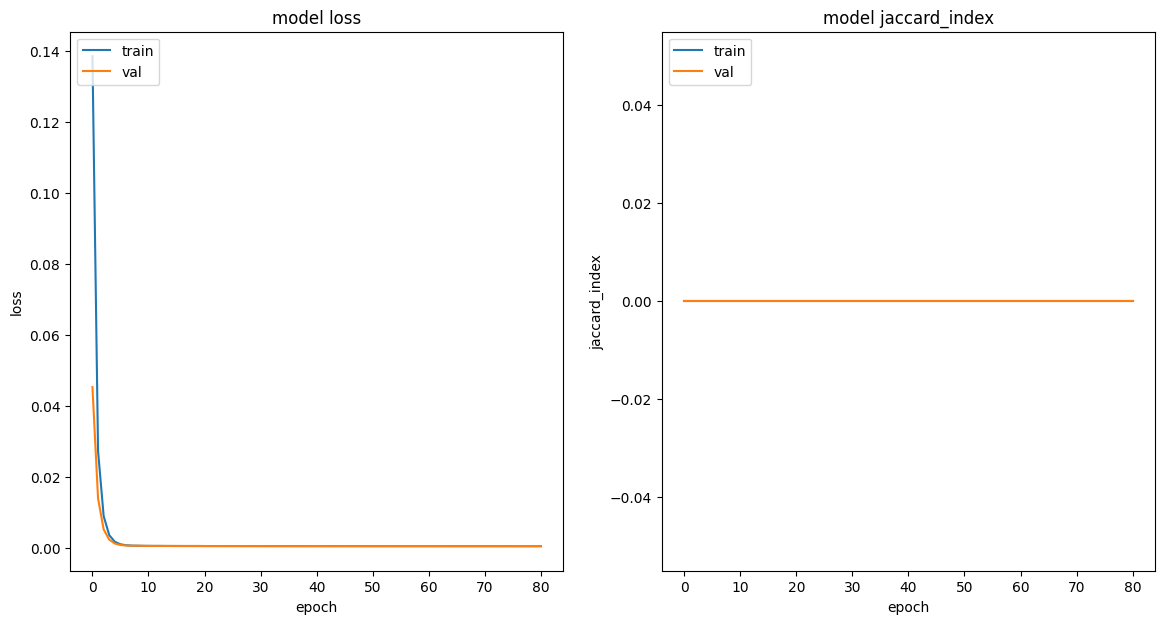

In [18]:
track_metrics = ['loss', 'psnr', 'ssim'] if loss_acronym == 'mse' else ['loss', 'jaccard_index']
curve_name = 'loss-metric_curve_' + test_datasets + '_.png'
create_dir(img_out_dir)
plot_loss_and_metric(track_metrics, history, figsize=(14,7), save_fig_path=os.path.join(img_out_dir, curve_name))

### Save weights

In [19]:
# Save weights for future reuse
create_dir(out_dir)
model.save_weights( weights_filename )
print( 'Saved model as ' + weights_filename )

Saved model as ./model_weights/weights-UNETR_2D-src-train-bce-nf-32-bs-6-AdamW-oneCycle.weights.h5


## Evaluation
\+ display examples

Method: Relevant patch with mirror padding

In [59]:
### FULL IMAGE using relevant patch + sliding window + mirror padding
print('TEST: ', test_datasets)
source_test_data_path = os.path.join(data_path, test_datasets)
test_img, test_lbl = get_xy_image_list(source_test_data_path)

# Prepare the test data
X_test = [x/255 for x in test_img] # normalize between 0 and 1
X_test = np.asarray(X_test, dtype=np.ndarray)
Y_test = [x/255 for x in test_lbl] # normalize between 0 and 1
Y_test = np.expand_dims( np.asarray(Y_test, dtype=np.ndarray), axis=-1 ) 

b =  X_test.shape[0]
h, w  = X_test[0].shape
c = 1
print("\nTest shape =", X_test.shape )
del test_img, test_lbl

TEST:  test
Input images loaded: 2590 -- Label images loaded: 2590
	path: /media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/test

Test shape = (2590, 256, 256)


In [58]:
# Now, we calculate the final test metrics
test_iou = []
test_psnr = []
test_ssim = []
test_mse = []
preds_test = []
input_test = []
i = 0

for img in X_test:


    h, w = img.shape
    
    if w%relevant_w != 0 and h%relevant_h != 0:
        w_parts = w/relevant_w
        h_parts = h/relevant_h
        new_w = int(np.ceil(w_parts))*relevant_w
        new_h = int(np.ceil(h_parts))*relevant_h
        pad_h = new_h - h # if pad==11 (odd): 6 top (near 0) - 5 bot
        pad_w = new_w - w # if pad==11 (odd): 6 L   (near 0) - 5 R
        same_shape_windows = False
    else:
        new_h = h + relevant_h
        new_w = w + relevant_w
        pad_h = relevant_h
        pad_w = relevant_w
        same_shape_windows = True

    image = mirror_border(img[:,:], relevant_h, relevant_w)

    rows = []
    x_rows = []
    # crete patches of (patch_h, patch_w) with (relevant_h, relevant_w) overlap between them
    for j in range(0, image.shape[0]-relevant_h, relevant_h): 

        is_first_column = j == 0
        is_last_column = j == (image.shape[0]-relevant_h*2)

        columns = [] # patches of the first row
        for k in range(0, image.shape[1]-relevant_w, relevant_w):
            window = image[j:j + patch_h, k:k + patch_w]
            columns.append( window )
        columns = np.array(columns,  dtype=np.ndarray)
        
        # prepare input and gt (y)
        if loss_acronym == 'mse':
            y = img[:,:,0]
            columns = np.array(columns*255, dtype='uint8')
            columns = crappify(columns)
            columns = np.array(columns, dtype='float32')/255
        else:
            y = Y_test[i,0]

        columns = np.expand_dims(columns, axis=-1)
        _preds_test = model.predict_on_batch(columns)#, batch_size=columns.shape[0])

        if same_shape_windows:
            #all the patches contain the same padding so we can extract them directly
            relevant_windows = _preds_test[ :, relevant_h//2 : patch_h-(relevant_h//2),
                                            relevant_w//2 : patch_w-(relevant_w//2), :]

            x_relevant = columns[ :, relevant_h//2 : patch_h-(relevant_h//2),
                                    relevant_w//2 : patch_w-(relevant_w//2), :]
        else:
            # if pad==11 (odd): 5 top (near 0) - 6 bot
            # if pad==11 (odd): 6 L   (near 0) - 5 R

            # pad_h//2 padding in the top side  &&  round(pad_h/2)-1 padding in the bottom side
            from_row = pad_h//2 if is_first_column else relevant_h//2
            to_row = -round(pad_h/2) if is_last_column else patch_h-(relevant_h//2) 

            # remove especial (smaller) padding in the top and bottom side, of the first or last row
            relevant_windows = _preds_test[ :, from_row : to_row, relevant_w//2 : patch_w - (relevant_w//2), :]
            x_relevant = columns[ :, from_row : to_row, relevant_w//2 : patch_w - (relevant_w//2), :]
            

            # convert into list otherwise numpy raise an error due to the shape differences
            relevant_windows = [im for im in relevant_windows]
            x_relevant = [im for im in x_relevant]


            # remove especial (smaller) padding in the sides
            # the relevant window contain round(pad_w/2) size padding in the left side
            from_column_L = round(pad_w/2)
            to_column_L = patch_w-(relevant_w//2)
            # the relevant window contain (pad_w//2) size padding in the right side
            from_column_R = relevant_w//2
            to_column_R = -(pad_w//2)
            
            # first column (left padding)
            relevant_windows[0] = _preds_test[0, from_row : to_row, from_column_L : to_column_L, :]
            x_relevant[0] = columns[0, from_row : to_row, from_column_L : to_column_L, :]
            # last column (right padding)
            relevant_windows[-1] = _preds_test[-1, from_row : to_row, from_column_R : to_column_R, :]
            x_relevant[-1] = columns[-1, from_row : to_row, from_column_R : to_column_R, :]
        
        rows.append(cv2.hconcat(relevant_windows)) # append relevant complete row
        x_rows.append(cv2.hconcat(x_relevant))

    x_recons = cv2.vconcat(x_rows)
    input_test.append(x_recons)
    recons_parts = cv2.vconcat(rows)
    preds_test.append(recons_parts) # append complete image

    if loss_acronym == 'mse':
        test_psnr.append(metrics.peak_signal_noise_ratio(recons_parts, y))
        test_ssim.append(metrics.structural_similarity(recons_parts, y))
        test_mse.append(metrics.mean_squared_error(recons_parts, y))
    else:
        test_iou.append( jaccard_index(y, recons_parts >= 0.5 ))     
    
    i+=1      
    

if loss_acronym == 'mse':
    mean_psnr = np.mean(test_psnr)
    mean_ssim = np.mean(test_ssim)
    mean_mse = np.mean(test_mse)
    print("\nTest PSNR:", mean_psnr)
    print("\nTest SSIM:", mean_ssim)
    print("\nTest MSE:", mean_mse)
else:
    mean_iou = np.mean(test_iou)
    print("\nTest IoU:", mean_iou)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

Inferring and measuring

In [53]:
# Now, we calculate the final test metrics
test_iou = []
test_psnr = []
test_ssim = []
test_mse = []
preds_test = []
input_test = []
i = 0

for img in X_test:


    h, w = img.shape
    
    if w%relevant_w != 0 and h%relevant_h != 0:
        w_parts = w/relevant_w
        h_parts = h/relevant_h
        new_w = int(np.ceil(w_parts))*relevant_w
        new_h = int(np.ceil(h_parts))*relevant_h
        pad_h = new_h - h # if pad==11 (odd): 6 top (near 0) - 5 bot
        pad_w = new_w - w # if pad==11 (odd): 6 L   (near 0) - 5 R
        same_shape_windows = False
    else:
        new_h = h + relevant_h
        new_w = w + relevant_w
        pad_h = relevant_h
        pad_w = relevant_w
        same_shape_windows = True

    image = mirror_border(img[:,:], relevant_h, relevant_w)

    rows = []
    x_rows = []
    # crete patches of (patch_h, patch_w) with (relevant_h, relevant_w) overlap between them
    for j in range(0, image.shape[0]-relevant_h, relevant_h): 

        is_first_column = j == 0
        is_last_column = j == (image.shape[0]-relevant_h*2)

        columns = [] # patches of the first row
        for k in range(0, image.shape[1]-relevant_w, relevant_w):
            window = image[j:j + patch_h, k:k + patch_w]
            columns.append( window )
        columns = np.array(columns,  dtype=np.ndarray)
        
        # prepare input and gt (y)
        if loss_acronym == 'mse':
            y = img[:,:,0]
            columns = np.array(columns*255, dtype='uint8')
            columns = crappify(columns)
            columns = np.array(columns, dtype='float32')/255
        else:
            y = Y_test[i,0]

        columns = np.expand_dims(columns, axis=-1)
        _preds_test = model.predict_on_batch(columns)#, batch_size=columns.shape[0])

        if same_shape_windows:
            #all the patches contain the same padding so we can extract them directly
            relevant_windows = _preds_test[ :, relevant_h//2 : patch_h-(relevant_h//2),
                                            relevant_w//2 : patch_w-(relevant_w//2), :]

            x_relevant = columns[ :, relevant_h//2 : patch_h-(relevant_h//2),
                                    relevant_w//2 : patch_w-(relevant_w//2), :]
        else:
            # if pad==11 (odd): 5 top (near 0) - 6 bot
            # if pad==11 (odd): 6 L   (near 0) - 5 R

            # pad_h//2 padding in the top side  &&  round(pad_h/2)-1 padding in the bottom side
            from_row = pad_h//2 if is_first_column else relevant_h//2
            to_row = -round(pad_h/2) if is_last_column else patch_h-(relevant_h//2) 

            # remove especial (smaller) padding in the top and bottom side, of the first or last row
            relevant_windows = _preds_test[ :, from_row : to_row, relevant_w//2 : patch_w - (relevant_w//2), :]
            x_relevant = columns[ :, from_row : to_row, relevant_w//2 : patch_w - (relevant_w//2), :]
            

            # convert into list otherwise numpy raise an error due to the shape differences
            relevant_windows = [im for im in relevant_windows]
            x_relevant = [im for im in x_relevant]


            # remove especial (smaller) padding in the sides
            # the relevant window contain round(pad_w/2) size padding in the left side
            from_column_L = round(pad_w/2)
            to_column_L = patch_w-(relevant_w//2)
            # the relevant window contain (pad_w//2) size padding in the right side
            from_column_R = relevant_w//2
            to_column_R = -(pad_w//2)
            
            # first column (left padding)
            relevant_windows[0] = _preds_test[0, from_row : to_row, from_column_L : to_column_L, :]
            x_relevant[0] = columns[0, from_row : to_row, from_column_L : to_column_L, :]
            # last column (right padding)
            relevant_windows[-1] = _preds_test[-1, from_row : to_row, from_column_R : to_column_R, :]
            x_relevant[-1] = columns[-1, from_row : to_row, from_column_R : to_column_R, :]
        
        rows.append(cv2.hconcat(relevant_windows)) # append relevant complete row
        x_rows.append(cv2.hconcat(x_relevant))

    x_recons = cv2.vconcat(x_rows)
    input_test.append(x_recons)
    recons_parts = cv2.vconcat(rows)
    preds_test.append(recons_parts) # append complete image

    if loss_acronym == 'mse':
        test_psnr.append(metrics.peak_signal_noise_ratio(recons_parts, y))
        test_ssim.append(metrics.structural_similarity(recons_parts, y))
        test_mse.append(metrics.mean_squared_error(recons_parts, y))
    else:
        test_iou.append( jaccard_index(y, recons_parts >= 0.5 ))     
    
    i+=1      
    

if loss_acronym == 'mse':
    mean_psnr = np.mean(test_psnr)
    mean_ssim = np.mean(test_ssim)
    mean_mse = np.mean(test_mse)
    print("\nTest PSNR:", mean_psnr)
    print("\nTest SSIM:", mean_ssim)
    print("\nTest MSE:", mean_mse)
else:
    mean_iou = np.mean(test_iou)
    print("\nTest IoU:", mean_iou)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
np.expand_dims(columns, axis=-1).shape

Show inference examples

In [ ]:
first_pred_img_name = 'first pred plot.png'
last_pred_img_name = 'last pred plot.png'

if loss_acronym == 'mse':
    display_list1 = [input_test[0], X_test[0,:,:,0], preds_test[0]]
    display_list2 = [input_test[-1], X_test[-1,:,:,0], preds_test[-1]]
    display_titles = ['Input full image', 'Ground Truth', 'Predicted image']
else:
    display_list1 = [X_test[0,:,:,0], Y_test[0,:,:,0], preds_test[0]>=.5, preds_test[0]]
    display_list2 = [X_test[-1,:,:,0], Y_test[-1,:,:,0], preds_test[-1]>=.5, preds_test[-1]]
    display_titles = ['Input Image', 'True Mask', 'Predicted Mask', 'Probability map']

plt.figure(figsize=(7*4,7))
display(display_list1,
        custom_size = True,
        save_fig_path = os.path.join(img_out_dir,first_pred_img_name),
        title = display_titles,
        )
plt.figure(figsize=(7*4,7))
display(display_list2,
        custom_size = True,
        save_fig_path = os.path.join(img_out_dir,last_pred_img_name),
        title = display_titles,
        )